In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr

import optax
jax.config.update('jax_platform_name', 'cpu')
#jax.config.update("jax_enable_x64", True)

import pickle


import sys

sys.path.append("../../GaussNeuro")
import gaussneuro as lib

sys.path.append("../scripts/fit")
import th1
import template



import matplotlib.pyplot as plt
#plt.style.use(['../paper.mplstyle'])

/var/home/dl543/Documents/Learning/nonparametric-modulated-renewal/notebooks/../../GaussNeuro/gaussneuro/likelihoods/renewal.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
#jax.config.update('jax_platform_name', 'cpu')
#jax.config.update("jax_enable_x64", True)

# seed everything
seed = 1234
prng_state = jax.random.PRNGKey(seed)
rng = np.random.default_rng(seed)

## Data

In [3]:
# data
data_path = "../data/th1/"
session_name = 'Mouse28_140313_wake_isi5'
max_ISI_order = 4

select_fracs = [0.0, 0.1]
dataset_dict = th1.spikes_dataset(session_name, data_path, max_ISI_order, select_fracs)

test_select_fracs = [0.1, 0.2]
test_dataset_dict = th1.spikes_dataset(session_name, data_path, max_ISI_order, test_select_fracs)

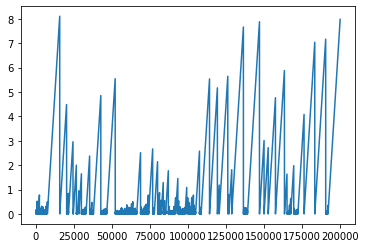

In [4]:
plt.plot(dataset_dict["ISIs"][:200000, 23, 0])

In [5]:
neurons = dataset_dict["properties"]["neurons"]

ts = 100
num_samps = 10

x_eval_tun = jnp.linspace(0, 2*np.pi, ts)[None, None, :, None]
x_eval_tun = jnp.broadcast_to(x_eval_tun, (num_samps, 1, ts, 1))

<a id='behav'></a>
## Poisson point process

In [34]:
### model ###
checkpoint_dir = '../scripts/checkpoint/'
name = (
    'Mouse28_140313_wake_isi5ISI5sel0.0to0.5_PP-log__factorized_gp-8-1000_X[hd]_Z[]_freeze[]'
#     'Mouse28_140313_wake_isi5ISI5sel0.0to0.5_' +
#     'PP-log_rcb-16-17.-36.-6.-30.-self-H500_factorized_gp-8-1000_' +
#     'X[hd]_Z[]_freeze[obs_model0spikefilter0a-' +
#     'obs_model0spikefilter0log_c-obs_model0spikefilter0phi]'
)


results = pickle.load(
    open(checkpoint_dir + name + ".p", "rb")
)
config = results["config"]
seed = results["best_seed"]


# data
timestamps, covs_t, ISIs, observations, filter_length = template.select_inputs(
    dataset_dict, config)
obs_covs_dims = covs_t.shape[-1]
timesteps = covs_t.shape[0]
spikes_t = observations.astype(bool)
max_intervals = spikes_t.sum(-1).max()

st = 0
xs = covs_t
deltas = ISIs[:, st:, :ISI_orders] if ISIs is not None else ISIs
ys = spikes_t[:, st:]
ys_filt = spikes_t[:, :]


# test
timestamps, covs_t, ISIs, observations, filter_length = template.select_inputs(
    test_dataset_dict, config)
test_xs = covs_t
test_timesteps = covs_t.shape[0]
test_deltas = ISIs[:, st:, :ISI_orders] if ISIs is not None else ISIs
test_ys = observations.astype(bool)[:, st:]
test_ys_filt = spikes_t[:, :]


# model
model = template.build_model(
    config, dataset_dict, th1.observed_kernel_dict_induc_list, rng, timestamps, obs_covs_dims)
model = eqx.tree_deserialise_leaves(checkpoint_dir + name + ".eqx", model)


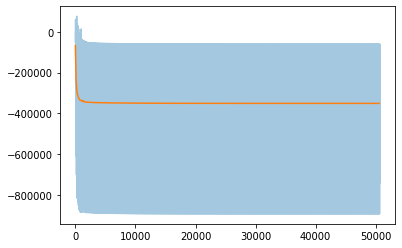

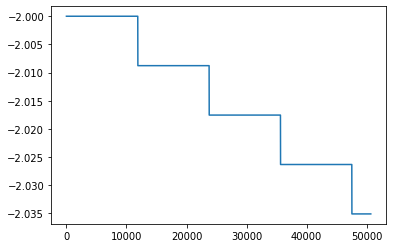

In [35]:
batches = len(results['losses']['train_loss_batches'])
epochs = len(results['losses']['train_loss_epochs'])
delta_be = batches // epochs

plt.plot(np.arange(batches), results['losses']['train_loss_batches'], alpha=0.4)
plt.plot(delta_be*np.arange(epochs), results['losses']['train_loss_epochs'])
plt.show()

plt.plot(np.log10(results['lrs']))
plt.show()

In [36]:
prng_state = jr.PRNGKey(123)
jitter = 1e-6
sel_outdims = None


post_mean_rho = model.obs_model.posterior_mean(
    xs, ys_filt, jitter, sel_outdims)

rescaled_intervals, _ = lib.utils.spikes.time_rescale(
    ys.T, post_mean_rho.T, model.obs_model.likelihood.dt, max_intervals=max_intervals)

pp = lib.likelihoods.ExponentialRenewal(
    model.obs_model.likelihood.obs_dims, model.obs_model.likelihood.dt)

qs = np.array(jax.vmap(pp.cum_density)(rescaled_intervals.T).T)
sort_cdfs, T_KSs, sign_KSs, p_KSs = [], [], [], []
for n in range(qs.shape[0]):
    ul = np.where(qs[n, :] != qs[n, :])[0]
    if len(ul) == 0:
        sort_cdf, T_KS, sign_KS, p_KS = None, None, None, None
    else:
        sort_cdf, T_KS, sign_KS, p_KS = lib.utils.stats.KS_test(qs[n, :ul[0]], alpha=0.05)
    sort_cdfs.append(sort_cdf)
    T_KSs.append(T_KS)
    sign_KSs.append(sign_KS)
    p_KSs.append(p_KS)


# # LPD
# lik_int_method = {
#     "type": "GH", 
#     "approx_pts": 50, 
# }

# train_ell, _ = model.obs_model.variational_expectation(
#     prng_state, jitter, xs[None, None], ys, ys_filt, False, timesteps, lik_int_method, False)

# test_lpd, _ = model.obs_model.variational_expectation(
#     prng_state, jitter, test_xs[None, None], test_ys, test_ys_filt, False, test_timesteps, lik_int_method, False)

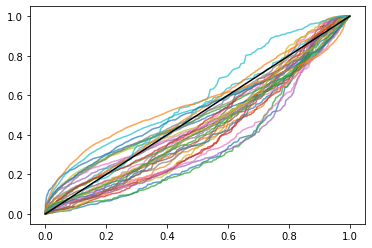

In [37]:
for n in range(len(sort_cdfs)):
    if sort_cdfs[n] is not None:
        plt.plot(np.linspace(0., 1., len(sort_cdfs[n])), sort_cdfs[n], alpha=0.7)
plt.plot(np.linspace(0., 1., 100), np.linspace(0., 1., 100), c='k')
plt.show()

#print(train_ell, test_lpd)

In [38]:
quantile_factors = [scipy.stats.norm.ppf(0.025), 0.5, scipy.stats.norm.ppf(0.975)]

pre_rates_mean, pre_rates_var, _ = model.obs_model.gp_posterior(
    x_eval_tun[:1, ...],
    mean_only=False,
    diag_cov=True,
    compute_KL=False,
    jitter=jitter,
    sel_outdims=sel_outdims, 
)  # (num_samps, out_dims, ts, 1)
pre_rates_mean, pre_rates_std = pre_rates_mean[0, ..., 0], jnp.sqrt(pre_rates_var[0, ..., 0])

post_quantiles = [model.obs_model.likelihood.inverse_link(
    pre_rates_mean + f*pre_rates_std) for f in quantile_factors]

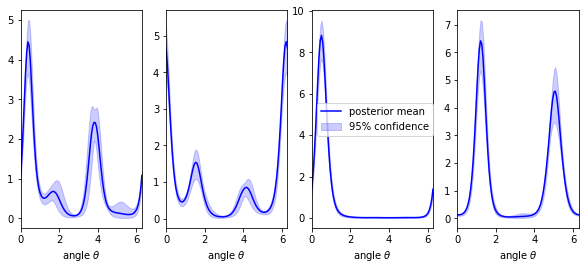

In [39]:
tr = list(range(num_samps))
plot_neurons = 4

fig, axes = plt.subplots(1, plot_neurons, figsize=(10, 4))

for f_dim in range(plot_neurons):
    ax = axes[f_dim]

    line, = ax.plot(x_eval_tun[0, 0, :, 0], post_quantiles[1][f_dim, :], 'b', label='posterior mean')
    ax.fill_between(x_eval_tun[0, 0, :, 0], post_quantiles[0][f_dim, :], post_quantiles[2][f_dim, :], 
                    color=line.get_color(), alpha=0.2, label='95% confidence')
    ax.set_xlim([x_eval_tun[0, 0, 0, 0], x_eval_tun[0, 0, -1, 0]])
    ax.set_xlabel(r'angle $\theta$')
    #ax.set_ylabel(r'$L = {}$'.format(Ls[s]))

    if f_dim == 2:
        ax.legend()
        
    #line, = ax.plot(covariates, rate[f_dim, :])
        

plt.show()

Sample posterior and compute intensities

In [29]:
ini_Y = jnp.zeros((num_samps, neurons, filter_length))

y_samples, log_rho_ts = model.obs_model.sample_posterior(
    prng_state, x_eval, ini_Y=ini_Y, jitter=jitter)

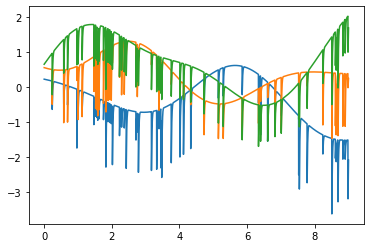

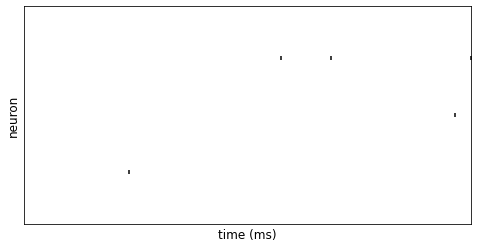

In [30]:
tr = 0

plt.plot(timestamps, log_rho_ts[tr, :, :].T)
plt.show()


fig, ax = plt.subplots(figsize=(8,4))
fig.set_facecolor('white')

lib.utils.plots.raster_plot((fig, ax), y_samples[tr, :, :], ts, dt*1000, neurons, markersize=10)
lib.utils.plots.decorate_ax(ax, xlabel='time (ms)', ylabel='neuron')

plt.show()

<a id='models_IPP'></a>
## Rate-rescaled renewal processes

In [78]:
### model ###
checkpoint_dir = '../scripts/checkpoint/'
name = 'Mouse28_140313_wake_isi5ISI5sel0.0to0.5_gamma-log__rate_renewal_gp-8-1000_X[hd]_Z[]_freeze[]'
#'Mouse28_140313_wake_isi5ISI5sel0.0to0.5_gamma-log__rate_renewal_gp-8-1000_X[hd]_Z[]_freeze[]'
#'Mouse28_140313_wake_isi5ISI5sel0.0to0.5_invgauss-log__rate_renewal_gp-8-1000_X[hd]_Z[]_freeze[]'


results = pickle.load(
    open(checkpoint_dir + name + ".p", "rb")
)
config = results["config"]
seed = results["best_seed"]


# data
timestamps, covs_t, ISIs, observations, filter_length = template.select_inputs(
    dataset_dict, config)
obs_covs_dims = covs_t.shape[-1]
timesteps = covs_t.shape[0]
spikes_t = observations.astype(bool)
max_intervals = spikes_t.sum(-1).max()


# model
model = template.build_model(
    config, dataset_dict, th1.observed_kernel_dict_induc_list, rng, timestamps, obs_covs_dims)
model = eqx.tree_deserialise_leaves(checkpoint_dir + name + ".eqx", model)


In [79]:
prng_state = jr.PRNGKey(123)
jitter = 1e-6
sel_outdims = None

st = 0
fltlen = 0
xs = covs_t
deltas = ISIs.transpose(1, 0, 2)[:, st:, :1] if ISIs is not None else ISIs
ys = spikes_t[:, st:]
ys_filt = spikes_t[:, st+fltlen:]

post_mean_rho = model.obs_model.posterior_mean(
    xs, ys_filt, jitter, sel_outdims)

rescaled_intervals, _ = lib.utils.spikes.time_rescale(
    ys.T, post_mean_rho.T, model.obs_model.renewal.dt, max_intervals=max_intervals)

#pp = lib.likelihoods.ExponentialRenewal(
#    model.obs_model.renewal.obs_dims, model.obs_model.renewal.dt)

#qs = np.array(pp.cum_density(rescaled_intervals))[:, 1:]
qs = np.array(jax.vmap(model.obs_model.renewal.cum_density)(rescaled_intervals.T).T)
sort_cdfs, T_KSs, sign_KSs, p_KSs = [], [], [], []
for n in range(qs.shape[0]):
    ul = np.where(qs[n, :] != qs[n, :])[0]
    if len(ul) == 0:
        sort_cdf, T_KS, sign_KS, p_KS = None, None, None, None
    else:
        sort_cdf, T_KS, sign_KS, p_KS = lib.utils.stats.KS_test(qs[n, :ul[0]], alpha=0.05)
    sort_cdfs.append(sort_cdf)
    T_KSs.append(T_KS)
    sign_KSs.append(sign_KS)
    p_KSs.append(p_KS)


# # LPD
# lik_int_method = {
#     "type": "GH", 
#     "approx_pts": 100, 
# }

# train_ell, _ = model.obs_model.variational_expectation(
#     prng_state, jitter, xs[None, None], ys, ys_filt, False, timesteps, lik_int_method, False)

#test_lpd, _ = model.obs_model.variational_expectation(
#    prng_state, jitter, test_xs[None, None], test_ys, False, test_timesteps, lik_int_method, False)

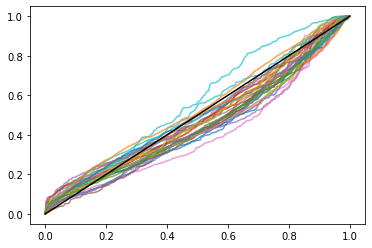

In [80]:
for n in range(len(sort_cdfs)):
    if sort_cdfs[n] is not None:
        plt.plot(np.linspace(0., 1., len(sort_cdfs[n])), sort_cdfs[n], alpha=0.7)
plt.plot(np.linspace(0., 1., 100), np.linspace(0., 1., 100), c='k')
plt.show()

#print(train_ell)

In [74]:
rescaled_intervals.shape

(33, 5744)

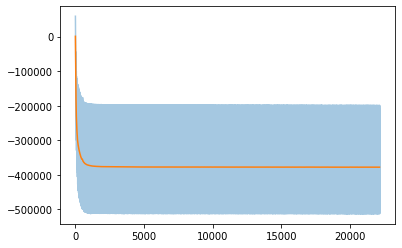

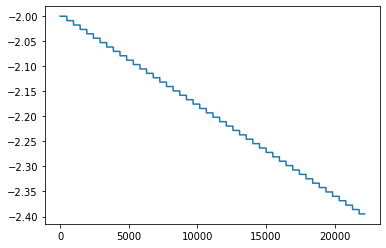

In [81]:
batches = len(results['losses']['train_loss_batches'])
epochs = len(results['losses']['train_loss_epochs'])
delta_be = batches // epochs

plt.plot(np.arange(batches), results['losses']['train_loss_batches'], alpha=0.4)
plt.plot(delta_be*np.arange(epochs), results['losses']['train_loss_epochs'])
plt.show()

plt.plot(np.log10(results['lrs']))
plt.show()

tuning curves

In [76]:
quantile_factors = [scipy.stats.norm.ppf(0.025), 0.5, scipy.stats.norm.ppf(0.975)]

pre_rates_mean, pre_rates_var, _ = model.obs_model.gp_posterior(
    x_eval_tun[:1, ...],
    mean_only=False,
    diag_cov=True,
    compute_KL=False,
    jitter=jitter,
    sel_outdims=sel_outdims,
)  # (num_samps, out_dims, ts, 1)
pre_rates_mean, pre_rates_std = pre_rates_mean[0, ..., 0], jnp.sqrt(pre_rates_var[0, ..., 0])

post_quantiles = [model.obs_model.renewal.inverse_link(
    pre_rates_mean + f*pre_rates_std) for f in quantile_factors]

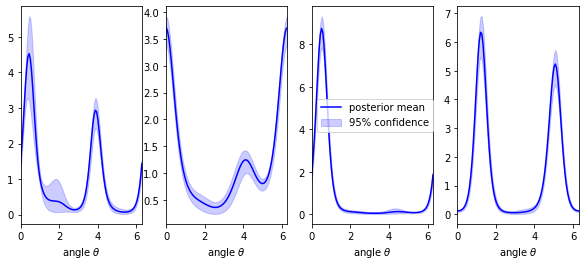

In [77]:
tr = list(range(num_samps))
plot_neurons = 4

fig, axes = plt.subplots(1, plot_neurons, figsize=(10, 4))

for f_dim in range(plot_neurons):
    ax = axes[f_dim]

    line, = ax.plot(x_eval_tun[0, 0, :, 0], post_quantiles[1][f_dim, :], 'b', label='posterior mean')
    ax.fill_between(x_eval_tun[0, 0, :, 0], post_quantiles[0][f_dim, :], post_quantiles[2][f_dim, :], 
                    color=line.get_color(), alpha=0.2, label='95% confidence')
    ax.set_xlim([x_eval_tun[0, 0, 0, 0], x_eval_tun[0, 0, -1, 0]])
    ax.set_xlabel(r'angle $\theta$')
    #ax.set_ylabel(r'$L = {}$'.format(Ls[s]))

    if f_dim == 2:
        ax.legend()
        
    #line, = ax.plot(covariates, rate[f_dim, :])
        

plt.show()

Sample posterior

In [117]:
ini_t_tilde = jnp.zeros((num_samps, neurons))

y_samples, log_rho_ts = model.obs_model.sample_posterior(
    prng_state, x_eval, ini_spikes=None, ini_t_tilde=ini_t_tilde, jitter=jitter)

In [35]:
tr = 0

plt.plot(timestamps, log_rho_ts[tr, :, :].T)
plt.show()


fig, ax = plt.subplots(figsize=(8,4))
fig.set_facecolor('white')

lib.utils.plots.raster_plot((fig, ax), y_samples[tr, :, :], ts, dt*1000, neurons, markersize=10)
lib.utils.plots.decorate_ax(ax, xlabel='time (ms)', ylabel='neuron')

plt.show()

NameError: name 'log_rho_ts' is not defined

In [70]:
jnp.nan_to_num(jnp.nan * jnp.ones(3))

Array([0., 0., 0.], dtype=float32)

<a id='models_CPP'></a>
## Conditional Poisson process

In [10]:
### model ###
checkpoint_dir = '../scripts/checkpoint/'
name = (
    'Mouse28_140313_wake_isi5ISI5sel0.0to0.5_' +
    'PP-log_rcb-16-17.-36.-6.-30.-self-H500_factorized_gp-8-1000_' +
    'X[hd]_Z[]_freeze[obs_model0spikefilter0a-' +
    'obs_model0spikefilter0log_c-obs_model0spikefilter0phi]'
)


results = pickle.load(
    open(checkpoint_dir + name + ".p", "rb")
)
config = results["config"]
seed = results["best_seed"]


# data
timestamps, covs_t, ISIs, observations, filter_length = template.select_inputs(
    dataset_dict, config)
obs_covs_dims = covs_t.shape[-1]
timesteps = covs_t.shape[0]
spikes_t = observations.astype(bool)
max_intervals = spikes_t.sum(-1).max()


# model
model = template.build_model(
    config, dataset_dict, th1.observed_kernel_dict_induc_list, rng, timestamps, obs_covs_dims)
model = eqx.tree_deserialise_leaves(checkpoint_dir + name + ".eqx", model)


In [69]:
prng_state = jr.PRNGKey(123)
jitter = 1e-6
sel_outdims = None


filter_t, KL = model.obs_model.spikefilter.compute_posterior(True, None, jitter)

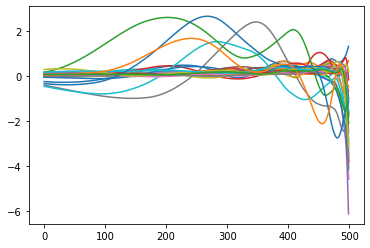

In [70]:
fig = plt.figure()
ax = fig.subplots()

t = np.arange(filter_t.shape[0])
ax.plot(t, filter_t[:, :, 0])
plt.show()

In [27]:
x_eval = covs_t[None, None]
ys_filt = observations[None, :, :-1]
ys = observations[None, :, filter_length:]

Predicted intensities on the data

In [66]:
#ini_Y = jnp.zeros((num_samps, neurons, filter_length))
#ys_filt = jnp.concatenate((ini_Y, ys[..., :-1]), axis=2)

pre_rates_mean, pre_rates_var, _ = model.obs_model.filtered_gp_posterior(
    prng_state, x_eval[:1], ys_filt=ys_filt, 
    mean_only=False, diag_cov=True, joint_filter_samples=False, 
    compute_KL=False, jitter=jitter, sel_outdims=None
)

pre_rates_mean, pre_rates_std = pre_rates_mean[0, ..., 0], jnp.sqrt(pre_rates_var)[0, ..., 0]

quantile_factors = [scipy.stats.norm.ppf(0.025), 0.5, scipy.stats.norm.ppf(0.975)]
post_quantiles = [model.obs_model.likelihood.inverse_link(
    pre_rates_mean + f*pre_rates_std) for f in quantile_factors]

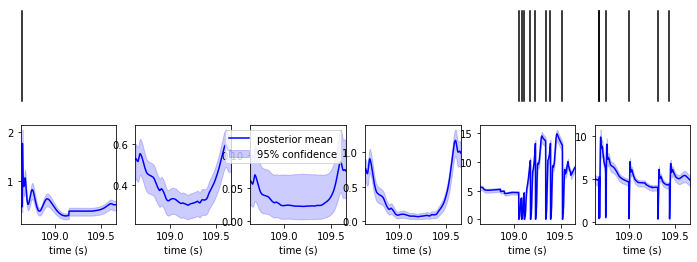

In [75]:
tr = list(range(num_samps))
plot_neurons = 6

ts = slice(8610, 9640)

fig, axes = plt.subplots(2, plot_neurons, figsize=(12, 4))

for f_dim in range(plot_neurons):
    ax = axes[0, f_dim]
    
    spiketimes = timestamps[np.where(ys[0, f_dim, :] > 0)[0]]
    for st in spiketimes:
        ax.plot(st*np.ones(2), np.linspace(0, 1, 2), c='k')
        
    ax.set_xlim([timestamps[ts][0], timestamps[ts][-1]])
    ax.axis('off')
    
    ax = axes[1, f_dim]

    line, = ax.plot(timestamps[ts], post_quantiles[1][f_dim, ts], 'b', label='posterior mean')
    ax.fill_between(timestamps[ts], post_quantiles[0][f_dim, ts], post_quantiles[2][f_dim, ts], 
                    color=line.get_color(), alpha=0.2, label='95% confidence')
    ax.set_xlim([timestamps[ts][0], timestamps[ts][-1]])
    ax.set_xlabel('time (s)')

    if f_dim == 2:
        ax.legend()

plt.show()

Sample posterior

In [29]:
ini_Y = jnp.zeros((num_samps, neurons, filter_length))

y_samples, log_rho_ts = model.obs_model.sample_posterior(
    prng_state, x_eval, ini_Y=ini_Y, jitter=jitter)

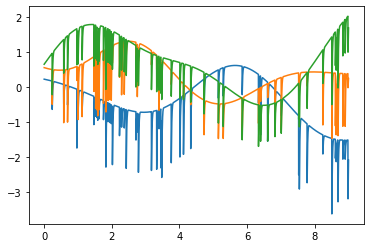

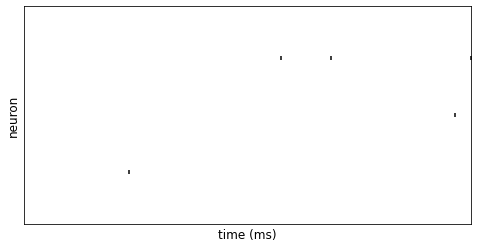

In [30]:
tr = 0

plt.plot(timestamps, log_rho_ts[tr, :, :].T)
plt.show()


fig, ax = plt.subplots(figsize=(8,4))
fig.set_facecolor('white')

lib.utils.plots.raster_plot((fig, ax), y_samples[tr, :, :], ts, dt*1000, neurons, markersize=10)
lib.utils.plots.decorate_ax(ax, xlabel='time (ms)', ylabel='neuron')

plt.show()

<a id='behav'></a>
## Nonparametric point process

In [8]:
### model ###
checkpoint_dir = '../scripts/checkpoint/'
ISI_orders = 4
name = 'Mouse28_140313_wake_isi5ISI5sel0.0to0.5_isi4__nonparam_pp_gp-40-matern32-matern32-1000-n2._' + \
    'X[hd]_Z[]_freeze[obs_model0log_warp_tau]'


results = pickle.load(
    open(checkpoint_dir + name + ".p", "rb")
)
config = results["config"]
seed = results["best_seed"]


# data
timestamps, covs_t, ISIs, observations, filter_length = template.select_inputs(
    dataset_dict, config)
obs_covs_dims = covs_t.shape[-1]
timesteps = covs_t.shape[0]
spikes_t = observations.astype(bool)
max_intervals = spikes_t.sum(-1).max()

st = 0
xs = covs_t
deltas = ISIs[:, st:, :ISI_orders] if ISIs is not None else ISIs
ys = spikes_t[:, st:]
ys_filt = spikes_t[:, st:]


# test
timestamps, covs_t, ISIs, observations, filter_length = template.select_inputs(
    test_dataset_dict, config)
test_xs = covs_t
test_timesteps = covs_t.shape[0]
test_deltas = ISIs[:, st:, :ISI_orders] if ISIs is not None else ISIs
test_ys = observations.astype(bool)


# model
model = template.build_model(
    config, dataset_dict, th1.observed_kernel_dict_induc_list, rng, timestamps, obs_covs_dims)
model = eqx.tree_deserialise_leaves(checkpoint_dir + name + ".eqx", model)


In [9]:
model.obs_model.gp.kernel

Product(
  array_type=0,
  in_dims=5,
  out_dims=33,
  kernels=[
    Matern32(
      array_type=0,
      in_dims=4,
      out_dims=33,
      state_dims=66,
      pre_len=f32[33,4],
      pre_var=f32[33]
    ),
    Periodic(
      array_type=0,
      in_dims=1,
      out_dims=33,
      state_dims=None,
      pre_len=f32[33,1],
      pre_var=f32[33]
    )
  ],
  dims_list=[[0, 1, 2, 3], [4]]
)

In [ ]:
prng_state = jr.PRNGKey(123)
jitter = 1e-6


post_mean_rho = model.obs_model.evaluate_posterior_mean(
    xs, deltas[None], jitter, sel_outdims=None)

rescaled_intervals = lib.utils.neural.time_rescale(
    ys.T, post_mean_rho.T, model.obs_model.pp.dt, max_intervals=max_intervals)

pp = lib.likelihoods.Exponential(
    model.obs_model.pp.obs_dims, model.obs_model.pp.dt)

qs = np.array(pp.cum_density(rescaled_intervals))[:, 1:]
sort_cdfs, T_KSs, sign_KSs, p_KSs = [], [], [], []
for n in range(qs.shape[0]):
    ul = np.where(qs[n, :] != qs[n, :])[0]
    if len(ul) == 0:
        sort_cdf, T_KS, sign_KS, p_KS = None, None, None, None
    else:
        sort_cdf, T_KS, sign_KS, p_KS = lib.utils.stats.KS_test(qs[n, :ul[0]], alpha=0.05)
    sort_cdfs.append(sort_cdf)
    T_KSs.append(T_KS)
    sign_KSs.append(sign_KS)
    p_KSs.append(p_KS)


# LPD
lik_int_method = {
    "type": "GH", 
    "approx_pts": 50, 
}

train_ell, _ = model.obs_model.variational_expectation(
    prng_state, jitter, xs[None, None], deltas, ys, False, timesteps, lik_int_method, False)

test_lpd, _ = model.obs_model.variational_expectation(
    prng_state, jitter, test_xs[None, None], test_deltas, test_ys, False, test_timesteps, lik_int_method, False)

In [ ]:
for n in range(len(sort_cdfs)):
    if sort_cdfs[n] is not None:
        plt.plot(np.linspace(0., 1., len(sort_cdfs[n])), sort_cdfs[n], alpha=0.7)
plt.plot(np.linspace(0., 1., 100), np.linspace(0., 1., 100), c='k')
plt.show()

print(train_ell, test_lpd)

In [50]:
upper = 0.1
x = np.linspace(0, upper, 100)
bins = np.linspace(0, upper, 50)
f = lib.utils.stats.KS_sampling_dist(x, len(sort_cdfs[0]))

/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


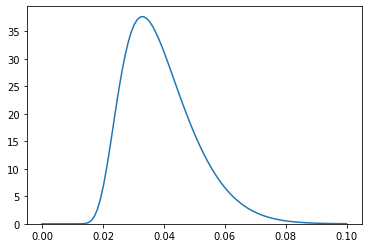

In [51]:
plt.plot(x, f)
plt.hist(T_KSs[0], bins=bins, density=True)
plt.show()

Sample posterior

In [70]:
ini_t_tilde = jnp.zeros((num_samps, neurons))

y_samples, log_rho_ts = model.obs_model.sample_posterior(
    prng_state, x_eval, ini_t_since=ini_t_since, jitter=jitter)

TypeError: NonparametricPointProcess.sample_posterior() missing 2 required positional arguments: 'x_samples' and 'past_ISIs'

Interspike interval distributions

In [8]:
evalsteps = 120
covs_dims = covs_t.shape[-1]

cisi_t_eval = jnp.linspace(0.0, 5., evalsteps)
isi_cond = jnp.ones((neurons, ISI_orders-1))

prng_state = jr.PRNGKey(123)


x_cond = 1.*jnp.ones(covs_dims)
ISI_density = model.obs_model.sample_conditional_ISI(
    prng_state,
    num_samps,
    cisi_t_eval,
    isi_cond, 
    x_cond,
    sel_outdims=None, 
    int_eval_pts=1000,
    num_quad_pts=100,
    prior=False,
    jitter=jitter, 
)


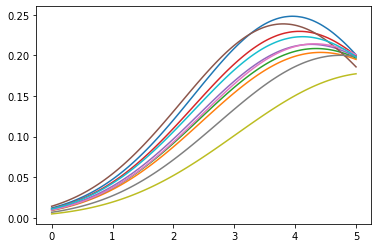

In [14]:
n = 12

plt.plot(cisi_t_eval, ISI_density[:, n, :].T)
plt.show()

Predicted intensity

In [ ]:
log_rho_t_mean, log_rho_t_cov = model.obs_model.evaluate_log_conditional_intensity(
    xs, deltas, jitter, sel_outdims)

Tuning curves

In [31]:
### evaluation ###
locs_eval = jnp.linspace(0, 2*np.pi, 30)[:, None]

n = 0
sel_outdims = jnp.array([n])
isi_cond = jnp.ones((len(sel_outdims), ISI_orders-1))

prng_state = jr.PRNGKey(123)

In [32]:
def m(x_cond, n):
    mean_ISI = model.obs_model.sample_conditional_ISI_expectation(
        prng_state,
        num_samps,
        lambda x: x,
        isi_cond, 
        x_cond,
        sel_outdims, 
        int_eval_pts=1000,
        f_num_quad_pts=100,
        isi_num_quad_pts=100, 
        prior=False,
        jitter=jitter, 
    )
    
    secmom_ISI = model.obs_model.sample_conditional_ISI_expectation(
        prng_state,
        num_samps,
        lambda x: x**2,
        isi_cond, 
        x_cond,
        sel_outdims, 
        int_eval_pts=1000,
        f_num_quad_pts=100,
        isi_num_quad_pts=100, 
        prior=False,
        jitter=jitter, 
    )

    var_ISI = (secmom_ISI - mean_ISI**2)
    CV_ISI = jnp.sqrt(var_ISI) / (mean_ISI + 1e-12)

    return mean_ISI, var_ISI, CV_ISI

In [33]:
mean_ISI, var_ISI, CV_ISI = jax.vmap(m, (0, None))(locs_eval, sel_outdims)

(10, 1, 1100, 5)


ValueError: vmap got inconsistent sizes for array axes to be mapped:
  * most axes (2 of them) had size 1, e.g. axis 0 of argument x of type float32[1,100,100];
  * one axis had size 33: axis 0 of argument fp of type float32[33,1000]

In [ ]:
n = 0
plt.plot(CV_ISI[:, :, n])
plt.show()


plt.plot(1/mean_ISI[:, :, n])
plt.show()

In [12]:
config.jitter

1e-06